# SUPER-RESOLUTION GAN
#### ALL CODES ARE FROM [SREZ](https://github.com/david-gpu/srez). 

In [1]:
import imageio
imageio.plugins.ffmpeg.download()
import os
import argparse
import random
import time
import numpy as np
import numpy.random
import scipy.misc 
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline  
print ("PACKAGES LOADED.")

PACKAGES LOADED.


# CONFIGURATION

In [2]:
# RESET EXISTING FLAG 
tf.app.flags.FLAGS = tf.python.platform.flags._FlagValues()
tf.app.flags._global_parser = argparse.ArgumentParser()
# SET FLAGS
tf.app.flags.DEFINE_integer('batch_size', 16,
                            "Number of samples per batch.")
tf.app.flags.DEFINE_string('checkpoint_dir', 'checkpoint',
                           "Output folder where checkpoints are dumped.")
tf.app.flags.DEFINE_integer('checkpoint_period', 10000,
                            "Number of batches in between checkpoints")
tf.app.flags.DEFINE_string('dataset', 'dataset',
                           "Path to the dataset directory.")
tf.app.flags.DEFINE_float('epsilon', 1e-8,
                          "Fuzz term to avoid numerical instability")
tf.app.flags.DEFINE_string('run', 'demo',
                            "Which operation to run. [demo|train]")
tf.app.flags.DEFINE_float('gene_l1_factor', 0.8,
                          "Multiplier for generator L1 loss term")
tf.app.flags.DEFINE_float('learning_beta1', 0.5,
                          "Beta1 parameter used for AdamOptimizer")
tf.app.flags.DEFINE_float('learning_rate_start', 0.00020,
                          "Starting learning rate used for AdamOptimizer")
tf.app.flags.DEFINE_integer('learning_rate_half_life', 5000,
                            "Number of batches until learning rate is halved")
tf.app.flags.DEFINE_bool('log_device_placement', False,
                         "Log the device where variables are placed.")
tf.app.flags.DEFINE_integer('sample_size', 64,
                            "Image sample size in pixels. Range [64,128]")
tf.app.flags.DEFINE_integer('summary_period', 3000,
                            "Number of batches between summary data dumps")
tf.app.flags.DEFINE_integer('random_seed', 0,
                            "Seed used to initialize rng.")
tf.app.flags.DEFINE_integer('test_vectors', 16,
                            """Number of features to use for testing""")
tf.app.flags.DEFINE_string('train_dir', 'train',
                           "Output folder where training logs are dumped.")
tf.app.flags.DEFINE_integer('train_time', 20,
                            "Time in minutes to train the model")
FLAGS = tf.app.flags.FLAGS

# SETUP TENSORFLOW

In [3]:
def setup_tensorflow():
    # Create session
    config = tf.ConfigProto(log_device_placement=FLAGS.log_device_placement)
    sess = tf.Session(config=config)
    # Initialize rng with a deterministic seed
    with sess.graph.as_default():
        tf.set_random_seed(FLAGS.random_seed)
    random.seed(FLAGS.random_seed)
    np.random.seed(FLAGS.random_seed)
    summary_writer = tf.summary.FileWriter(FLAGS.train_dir, sess.graph)
    return sess, summary_writer

In [4]:
sess, summary_writer = setup_tensorflow()
print ("SETUP TF SESSION AND SUMMARY")

SETUP TF SESSION AND SUMMARY


# PREPARE DIRECTORIES

In [5]:
def prepare_dirs(delete_train_dir=False):
    # CREATE CHECKPOINT DIRECTORIES
    if not tf.gfile.Exists(FLAGS.checkpoint_dir):
        tf.gfile.MakeDirs(FLAGS.checkpoint_dir)
        print ("CREATE CHECKPOINT FOLDER[%s]" % (FLAGS.checkpoint_dir))
    else:
        print ("CHECKPOINT FOLDER[%s] ALREADY EXISTS" % (FLAGS.checkpoint_dir))
    # CLEANUP TRAIN DIR
    if delete_train_dir:
        if tf.gfile.Exists(FLAGS.train_dir):
            tf.gfile.DeleteRecursively(FLAGS.train_dir)
            print ("DELETE EVERY FILES IN TRAIN FOLDER[%s]" % (FLAGS.train_dir))
        tf.gfile.MakeDirs(FLAGS.train_dir)
        print ("CREATE TRAIN FOLDER[%s]" % (FLAGS.train_dir))
        
    # Return names of training files
    if not tf.gfile.Exists(FLAGS.dataset) or \
        not tf.gfile.IsDirectory(FLAGS.dataset):
        print ("DATASET FOLDER[%s] DOES NOT EXIST" % (FLAGS.dataset))
        return
    else:
        print ("DATASET FOLDER[%s] EXISTS" % (FLAGS.dataset))
    # LOAD FILES IN THE DATASET FOLDER
    filenames = tf.gfile.ListDirectory(FLAGS.dataset)
    filenames = sorted(filenames)
    random.shuffle(filenames)
    filenames = [os.path.join(FLAGS.dataset, f) \
                 for f in filenames if os.path.splitext(f)[1] == '.jpg']
    return filenames

In [6]:
all_filenames = prepare_dirs(delete_train_dir=True)
print ("[%d] IMAGES LOADED." % (len(all_filenames)))

CHECKPOINT FOLDER[checkpoint] ALREADY EXISTS
DELETE EVERY FILES IN TRAIN FOLDER[train]
CREATE TRAIN FOLDER[train]
DATASET FOLDER[dataset] EXISTS
[202599] IMAGES LOADED.


# SEPARATE TRAINING AND TEST SETS

In [7]:
train_filenames = all_filenames[:-FLAGS.test_vectors]
test_filenames  = all_filenames[-FLAGS.test_vectors:]
print ("[%d] TRAIN IMAGES" % (len(train_filenames)))
print ("[%d] TEST IMAGES" % (len(test_filenames)))

[202583] TRAIN IMAGES
[16] TEST IMAGES


# SETUP INPUTS

In [8]:
def setup_inputs(sess, filenames, image_size=None, capacity_factor=3):
    if image_size is None:
        image_size = FLAGS.sample_size
    # READ JPEG IMAGES
    reader = tf.WholeFileReader()
    filename_queue = tf.train.string_input_producer(filenames)
    key, value = reader.read(filename_queue)
    channels = 3
    image = tf.image.decode_jpeg(value, channels=channels, name="dataset_image")
    image.set_shape([None, None, channels])
    # RANDOM AUGMENTATIONS
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, .95, 1.05)
    image = tf.image.random_brightness(image, .05)
    image = tf.image.random_contrast(image, .95, 1.05)
    # RANDOM CROP
    wiggle = 8
    off_x, off_y = 25-wiggle, 60-wiggle
    crop_size = 128
    crop_size_plus = crop_size + 2*wiggle
    image = tf.image.crop_to_bounding_box(image, off_y, off_x, crop_size_plus, crop_size_plus)
    image = tf.random_crop(image, [crop_size, crop_size, 3])
    image = tf.reshape(image, [1, crop_size, crop_size, 3])
    image = tf.cast(image, tf.float32)/255.0
    if crop_size != image_size:
        image = tf.image.resize_area(image, [image_size, image_size])

    # THE INPUT IS SIMPLY A K-DOWNSCALED VERSION
    K = 4
    downsampled = tf.image.resize_area(image, [image_size//K, image_size//K])
    feature = tf.reshape(downsampled, [image_size//K, image_size//K, 3])
    label   = tf.reshape(image,       [image_size,   image_size,     3])
    # USE ASYNCHRONOUS QUEUES 
    features, labels = tf.train.batch([feature, label],
                                      batch_size=FLAGS.batch_size,
                                      num_threads=4,
                                      capacity = capacity_factor*FLAGS.batch_size,
                                      name='labels_and_features')
    tf.train.start_queue_runners(sess=sess)
    return features, labels

In [9]:
train_features, train_labels = setup_inputs(sess, train_filenames)
test_features,  test_labels  = setup_inputs(sess, test_filenames)
print ("BATCH SIZE IS [%d]"     % (FLAGS.batch_size))
print ("train_features is [%s]" % (train_features))
print ("train_labels is [%s]"   % (train_labels)) 
print ("test_features is [%s]"  % (test_features)) 
print ("test_labels is [%s]"    % (test_labels)) 

BATCH SIZE IS [16]
train_features is [Tensor("labels_and_features:0", shape=(16, 16, 16, 3), dtype=float32)]
train_labels is [Tensor("labels_and_features:1", shape=(16, 64, 64, 3), dtype=float32)]
test_features is [Tensor("labels_and_features_1:0", shape=(16, 16, 16, 3), dtype=float32)]
test_labels is [Tensor("labels_and_features_1:1", shape=(16, 64, 64, 3), dtype=float32)]


# ADDING NOISE TO TRAIN FEATURES

In [10]:
noise_level = .03
noisy_train_features = train_features + \
    tf.random_normal(train_features.get_shape(), stddev=noise_level)

# MODEL CLASS

In [11]:
class Model:    
    def __init__(self, name, features):
        self.name = name
        self.outputs = [features]
    def _get_layer_str(self, layer=None):
        if layer is None:
            layer = self.get_num_layers()
        return '%s_L%03d' % (self.name, layer+1)
    def _get_num_inputs(self):
        return int(self.get_output().get_shape()[-1])
    def _glorot_initializer(self, prev_units, num_units, stddev_factor=1.0):
        """Initialization in the style of Glorot 2010.
        stddev_factor should be 1.0 for linear activations, and 2.0 for ReLUs"""
        stddev  = np.sqrt(stddev_factor / np.sqrt(prev_units*num_units))
        return tf.truncated_normal([prev_units, num_units],
                                    mean=0.0, stddev=stddev)
    def _glorot_initializer_conv2d(self, prev_units, num_units, mapsize, stddev_factor=1.0):
        """Initialization in the style of Glorot 2010.
        stddev_factor should be 1.0 for linear activations, and 2.0 for ReLUs"""
        stddev  = np.sqrt(stddev_factor / (np.sqrt(prev_units*num_units)*mapsize*mapsize))
        return tf.truncated_normal([mapsize, mapsize, prev_units, num_units],
                                    mean=0.0, stddev=stddev)
    def get_num_layers(self):
        return len(self.outputs)
    def add_batch_norm(self, scale=False):
        """Adds a batch normalization layer to this model.
        See ArXiv 1502.03167v3 for details."""
        # TBD: This appears to be very flaky, often raising InvalidArgumentError internally
        with tf.variable_scope(self._get_layer_str()):
            out = tf.contrib.layers.batch_norm(self.get_output(), scale=scale)
        self.outputs.append(out)
        return self
    def add_flatten(self):
        """Transforms the output of this network to a 1D tensor"""
        with tf.variable_scope(self._get_layer_str()):
            batch_size = int(self.get_output().get_shape()[0])
            out = tf.reshape(self.get_output(), [batch_size, -1])
        self.outputs.append(out)
        return self
    def add_dense(self, num_units, stddev_factor=1.0):
        """Adds a dense linear layer to this model.
        Uses Glorot 2010 initialization assuming linear activation."""
        assert len(self.get_output().get_shape()) == 2, "Previous layer must be 2-dimensional (batch, channels)"
        with tf.variable_scope(self._get_layer_str()):
            prev_units = self._get_num_inputs()
            # Weight term
            initw   = self._glorot_initializer(prev_units, num_units,
                                               stddev_factor=stddev_factor)
            weight  = tf.get_variable('weight', initializer=initw)
            # Bias term
            initb   = tf.constant(0.0, shape=[num_units])
            bias    = tf.get_variable('bias', initializer=initb)
            # Output of this layer
            out     = tf.matmul(self.get_output(), weight) + bias
        self.outputs.append(out)
        return self
    def add_sigmoid(self):
        """Adds a sigmoid (0,1) activation function layer to this model."""
        with tf.variable_scope(self._get_layer_str()):
            prev_units = self._get_num_inputs()
            out = tf.nn.sigmoid(self.get_output())
        self.outputs.append(out)
        return self
    def add_softmax(self):
        """Adds a softmax operation to this model"""
        with tf.variable_scope(self._get_layer_str()):
            this_input = tf.square(self.get_output())
            reduction_indices = list(range(1, len(this_input.get_shape())))
            acc = tf.reduce_sum(this_input, reduction_indices=reduction_indices, keep_dims=True)
            out = this_input / (acc+FLAGS.epsilon)
            #out = tf.verify_tensor_all_finite(out, "add_softmax failed; is sum equal to zero?")
        self.outputs.append(out)
        return self
    def add_relu(self):
        """Adds a ReLU activation function to this model"""
        with tf.variable_scope(self._get_layer_str()):
            out = tf.nn.relu(self.get_output())
        self.outputs.append(out)
        return self        
    def add_elu(self):
        """Adds a ELU activation function to this model"""
        with tf.variable_scope(self._get_layer_str()):
            out = tf.nn.elu(self.get_output())
        self.outputs.append(out)
        return self
    def add_lrelu(self, leak=.2):
        """Adds a leaky ReLU (LReLU) activation function to this model"""
        with tf.variable_scope(self._get_layer_str()):
            t1  = .5 * (1 + leak)
            t2  = .5 * (1 - leak)
            out = t1 * self.get_output() + \
                  t2 * tf.abs(self.get_output())
        self.outputs.append(out)
        return self
    def add_conv2d(self, num_units, mapsize=1, stride=1, stddev_factor=1.0):
        """Adds a 2D convolutional layer."""
        assert len(self.get_output().get_shape()) == 4 and "Previous layer must be 4-dimensional (batch, width, height, channels)"
        with tf.variable_scope(self._get_layer_str()):
            prev_units = self._get_num_inputs()
            # Weight term and convolution
            initw  = self._glorot_initializer_conv2d(prev_units, num_units,
                                                     mapsize,
                                                     stddev_factor=stddev_factor)
            weight = tf.get_variable('weight', initializer=initw)
            out    = tf.nn.conv2d(self.get_output(), weight,
                                  strides=[1, stride, stride, 1],
                                  padding='SAME')
            # Bias term
            initb  = tf.constant(0.0, shape=[num_units])
            bias   = tf.get_variable('bias', initializer=initb)
            out    = tf.nn.bias_add(out, bias)
        self.outputs.append(out)
        return self
    def add_conv2d_transpose(self, num_units, mapsize=1, stride=1, stddev_factor=1.0):
        """Adds a transposed 2D convolutional layer"""
        assert len(self.get_output().get_shape()) == 4 and "Previous layer must be 4-dimensional (batch, width, height, channels)"
        with tf.variable_scope(self._get_layer_str()):
            prev_units = self._get_num_inputs()
            # Weight term and convolution
            initw  = self._glorot_initializer_conv2d(prev_units, num_units,
                                                     mapsize,
                                                     stddev_factor=stddev_factor)
            weight = tf.get_variable('weight', initializer=initw)
            weight = tf.transpose(weight, perm=[0, 1, 3, 2])
            prev_output = self.get_output()
            output_shape = [FLAGS.batch_size,
                            int(prev_output.get_shape()[1]) * stride,
                            int(prev_output.get_shape()[2]) * stride,
                            num_units]
            out    = tf.nn.conv2d_transpose(self.get_output(), weight,
                                            output_shape=output_shape,
                                            strides=[1, stride, stride, 1],
                                            padding='SAME')
            # Bias term
            initb  = tf.constant(0.0, shape=[num_units])
            bias   = tf.get_variable('bias', initializer=initb)
            out    = tf.nn.bias_add(out, bias)
        self.outputs.append(out)
        return self
    def add_residual_block(self, num_units, mapsize=3, num_layers=2, stddev_factor=1e-3):
        """Adds a residual block as per Arxiv 1512.03385, Figure 3"""
        assert len(self.get_output().get_shape()) == 4 and "Previous layer must be 4-dimensional (batch, width, height, channels)"
        # Add projection in series if needed prior to shortcut
        if num_units != int(self.get_output().get_shape()[3]):
            self.add_conv2d(num_units, mapsize=1, stride=1, stddev_factor=1.)
        bypass = self.get_output()
        # Residual block
        for _ in range(num_layers):
            self.add_batch_norm()
            self.add_relu()
            self.add_conv2d(num_units, mapsize=mapsize, stride=1, stddev_factor=stddev_factor)
        self.add_sum(bypass)
        return self
    def add_bottleneck_residual_block(self, num_units, mapsize=3, stride=1, transpose=False):
        """Adds a bottleneck residual block as per Arxiv 1512.03385, Figure 3"""
        assert len(self.get_output().get_shape()) == 4 and "Previous layer must be 4-dimensional (batch, width, height, channels)"
        # Add projection in series if needed prior to shortcut
        if num_units != int(self.get_output().get_shape()[3]) or stride != 1:
            ms = 1 if stride == 1 else mapsize
            #bypass.add_batch_norm() # TBD: Needed?
            if transpose:
                self.add_conv2d_transpose(num_units, mapsize=ms, stride=stride, stddev_factor=1.)
            else:
                self.add_conv2d(num_units, mapsize=ms, stride=stride, stddev_factor=1.)
        bypass = self.get_output()
        # Bottleneck residual block
        self.add_batch_norm()
        self.add_relu()
        self.add_conv2d(num_units//4, mapsize=1,       stride=1,      stddev_factor=2.)
        self.add_batch_norm()
        self.add_relu()
        if transpose:
            self.add_conv2d_transpose(num_units//4,
                                      mapsize=mapsize,
                                      stride=1,
                                      stddev_factor=2.)
        else:
            self.add_conv2d(num_units//4,
                            mapsize=mapsize,
                            stride=1,
                            stddev_factor=2.)
        self.add_batch_norm()
        self.add_relu()
        self.add_conv2d(num_units,    mapsize=1,       stride=1,      stddev_factor=2.)
        self.add_sum(bypass)
        return self
    def add_sum(self, term):
        """Adds a layer that sums the top layer with the given term"""
        with tf.variable_scope(self._get_layer_str()):
            prev_shape = self.get_output().get_shape()
            term_shape = term.get_shape()
            #print("%s %s" % (prev_shape, term_shape))
            assert prev_shape == term_shape and "Can't sum terms with a different size"
            out = tf.add(self.get_output(), term)
        self.outputs.append(out)
        return self
    def add_mean(self):
        """Adds a layer that averages the inputs from the previous layer"""
        with tf.variable_scope(self._get_layer_str()):
            prev_shape = self.get_output().get_shape()
            reduction_indices = list(range(len(prev_shape)))
            assert len(reduction_indices) > 2 and "Can't average a (batch, activation) tensor"
            reduction_indices = reduction_indices[1:-1]
            out = tf.reduce_mean(self.get_output(), reduction_indices=reduction_indices)
        self.outputs.append(out)
        return self
    def add_upscale(self):
        """Adds a layer that upscales the output by 2x through nearest neighbor interpolation"""
        prev_shape = self.get_output().get_shape()
        size = [2 * int(s) for s in prev_shape[1:3]]
        out  = tf.image.resize_nearest_neighbor(self.get_output(), size)
        self.outputs.append(out)
        return self        
    def get_output(self):
        """Returns the output from the topmost layer of the network"""
        return self.outputs[-1]
    def get_variable(self, layer, name):
        """Returns a variable given its layer and name.
        The variable must already exist."""
        scope      = self._get_layer_str(layer)
        collection = tf.get_collection(tf.GraphKeys.VARIABLES, scope=scope)
        # TBD: Ugly!
        for var in collection:
            if var.name[:-2] == scope+'/'+name:
                return var
        return None
    def get_all_layer_variables(self, layer):
        """Returns all variables in the given layer"""
        scope = self._get_layer_str(layer)
        return tf.get_collection(tf.GraphKeys.VARIABLES, scope=scope)

# GENERATOR

In [12]:
def _generator_model(sess, features, labels, channels):
    # Upside-down all-convolutional resnet
    mapsize = 3
    res_units  = [256, 128, 96]
    old_vars = tf.global_variables()
    # See Arxiv 1603.05027
    model = Model('GEN', features)
    for ru in range(len(res_units)-1):
        nunits  = res_units[ru]
        for j in range(2):
            model.add_residual_block(nunits, mapsize=mapsize)
        # Spatial upscale (see http://distill.pub/2016/deconv-checkerboard/)
        # and transposed convolution
        model.add_upscale()
        model.add_batch_norm()
        model.add_relu()
        model.add_conv2d_transpose(nunits, mapsize=mapsize, stride=1, stddev_factor=1.)
    # Finalization a la "all convolutional net"
    nunits = res_units[-1]
    model.add_conv2d(nunits, mapsize=mapsize, stride=1, stddev_factor=2.)
    # Worse: model.add_batch_norm()
    model.add_relu()
    model.add_conv2d(nunits, mapsize=1, stride=1, stddev_factor=2.)
    # Worse: model.add_batch_norm()
    model.add_relu()
    # Last layer is sigmoid with no batch normalization
    model.add_conv2d(channels, mapsize=1, stride=1, stddev_factor=1.)
    model.add_sigmoid()
    new_vars  = tf.global_variables()
    gene_vars = list(set(new_vars) - set(old_vars))
    return model.get_output(), gene_vars

print ("GENERATOR READY")

GENERATOR READY


# DISCRIMINATOR

In [13]:
def _discriminator_model(sess, features, disc_input):
    # Fully convolutional model
    mapsize = 3
    layers  = [64, 128, 256, 512]
    old_vars = tf.global_variables()
    model = Model('DIS', 2*disc_input - 1)
    for layer in range(len(layers)):
        nunits = layers[layer]
        stddev_factor = 2.0
        model.add_conv2d(nunits, mapsize=mapsize, stride=2, stddev_factor=stddev_factor)
        model.add_batch_norm()
        model.add_relu()
    # Finalization a la "all convolutional net"
    model.add_conv2d(nunits, mapsize=mapsize, stride=1, stddev_factor=stddev_factor)
    model.add_batch_norm()
    model.add_relu()
    model.add_conv2d(nunits, mapsize=1, stride=1, stddev_factor=stddev_factor)
    model.add_batch_norm()
    model.add_relu()
    # Linearly map to real/fake and return average score
    # (softmax will be applied later)
    model.add_conv2d(1, mapsize=1, stride=1, stddev_factor=stddev_factor)
    model.add_mean()
    new_vars  = tf.global_variables()
    disc_vars = list(set(new_vars) - set(old_vars))
    return model.get_output(), disc_vars

print ("DISCRIMINATOR READY")

DISCRIMINATOR READY


# CREATE SR-GAN MODEL

In [14]:
def create_model(sess, features, labels):
    # Generator
    rows      = int(features.get_shape()[1])
    cols      = int(features.get_shape()[2])
    channels  = int(features.get_shape()[3])
    gene_minput = tf.placeholder(tf.float32, shape=[FLAGS.batch_size, rows, cols, channels])
    
    # TBD: Is there a better way to instance the generator?
    with tf.variable_scope('gene') as scope:
        gene_output, gene_var_list = \
                    _generator_model(sess, features, labels, channels)
        scope.reuse_variables()
        gene_moutput, _ = _generator_model(sess, gene_minput, labels, channels)
    # Discriminator with real data
    disc_real_input = tf.identity(labels, name='disc_real_input')
    # TBD: Is there a better way to instance the discriminator?
    with tf.variable_scope('disc') as scope:
        disc_real_output, disc_var_list = \
                _discriminator_model(sess, features, disc_real_input)
        scope.reuse_variables()
        disc_fake_output, _ = _discriminator_model(sess, features, gene_output)
    return [gene_minput,      gene_moutput,
            gene_output,      gene_var_list,
            disc_real_output, disc_fake_output, disc_var_list]

In [15]:
[gene_minput, gene_moutput, gene_output, gene_var_list,
    disc_real_output, disc_fake_output, disc_var_list] \
    = create_model(sess, noisy_train_features, train_labels) 

# GENERATOR LOSS

In [16]:
def _downscale(images, K):
    """Differentiable image downscaling by a factor of K"""
    arr = np.zeros([K, K, 3, 3])
    arr[:,:,0,0] = 1.0/(K*K)
    arr[:,:,1,1] = 1.0/(K*K)
    arr[:,:,2,2] = 1.0/(K*K)
    dowscale_weight = tf.constant(arr, dtype=tf.float32)    
    downscaled = tf.nn.conv2d(images, dowscale_weight,
                              strides=[1, K, K, 1],
                              padding='SAME')
    return downscaled

def create_generator_loss(disc_output, gene_output, features):
    # I.e. did we fool the discriminator?
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(disc_output, tf.ones_like(disc_output))
    gene_ce_loss  = tf.reduce_mean(cross_entropy, name='gene_ce_loss')
    # I.e. does the result look like the feature?
    K = int(gene_output.get_shape()[1])//int(features.get_shape()[1])
    assert K == 2 or K == 4 or K == 8    
    downscaled = _downscale(gene_output, K)
    gene_l1_loss  = tf.reduce_mean(tf.abs(downscaled - features), name='gene_l1_loss')
    gene_loss     = tf.add((1.0 - FLAGS.gene_l1_factor) * gene_ce_loss,
                           FLAGS.gene_l1_factor * gene_l1_loss, name='gene_loss')
    return gene_loss

In [17]:
gene_loss = create_generator_loss(disc_fake_output, gene_output, train_features)

# DISCRIMINATOR LOSS

In [18]:
def create_discriminator_loss(disc_real_output, disc_fake_output):
    # I.e. did we correctly identify the input as real or not?
    cross_entropy_real = tf.nn.sigmoid_cross_entropy_with_logits(disc_real_output, tf.ones_like(disc_real_output))
    disc_real_loss     = tf.reduce_mean(cross_entropy_real, name='disc_real_loss')
    cross_entropy_fake = tf.nn.sigmoid_cross_entropy_with_logits(disc_fake_output, tf.zeros_like(disc_fake_output))
    disc_fake_loss     = tf.reduce_mean(cross_entropy_fake, name='disc_fake_loss')
    return disc_real_loss, disc_fake_loss

In [19]:
disc_real_loss, disc_fake_loss = \
    create_discriminator_loss(disc_real_output, disc_fake_output)
disc_loss = tf.add(disc_real_loss, disc_fake_loss, name='disc_loss')

# OPTIMIZER

In [20]:
def create_optimizers(gene_loss, gene_var_list,
                      disc_loss, disc_var_list):    
    global_step    = tf.Variable(0, dtype=tf.int64,   trainable=False, name='global_step')
    learning_rate  = tf.placeholder(dtype=tf.float32, name='learning_rate')
    gene_opti = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                       beta1=FLAGS.learning_beta1,
                                       name='gene_optimizer')
    disc_opti = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                       beta1=FLAGS.learning_beta1,
                                       name='disc_optimizer')
    gene_minimize = gene_opti.minimize(gene_loss, var_list=gene_var_list
                                       , name='gene_loss_minimize', global_step=global_step)
    disc_minimize = disc_opti.minimize(disc_loss, var_list=disc_var_list
                                       , name='disc_loss_minimize', global_step=global_step)
    return (global_step, learning_rate, gene_minimize, disc_minimize)

In [21]:
(global_step, learning_rate, gene_minimize, disc_minimize) = \
    create_optimizers(gene_loss, gene_var_list, disc_loss, disc_var_list)

# TRAIN

In [22]:
class TrainData(object):
    def __init__(self, dictionary):
        self.__dict__.update(dictionary)
train_data = TrainData(locals())

In [23]:
def _summarize_progress(train_data, feature, label, gene_output, batch, suffix, max_samples=8):
    td = train_data
    size = [label.shape[1], label.shape[2]]
    nearest = tf.image.resize_nearest_neighbor(feature, size)
    nearest = tf.maximum(tf.minimum(nearest, 1.0), 0.0)
    bicubic = tf.image.resize_bicubic(feature, size)
    bicubic = tf.maximum(tf.minimum(bicubic, 1.0), 0.0)
    clipped = tf.maximum(tf.minimum(gene_output, 1.0), 0.0)
    image   = tf.concat(2, [nearest, bicubic, clipped, label])

    image = image[0:max_samples,:,:,:]
    image = tf.concat(0, [image[i,:,:,:] for i in range(max_samples)])
    image = td.sess.run(image)

    _filename = 'batch%06d_%s.png' % (batch, suffix)
    filename = os.path.join(FLAGS.train_dir, _filename)
    scipy.misc.toimage(image, cmin=0., cmax=1.).save(filename)
    print("    Saved %s" % (filename,))
    # ADDITIONAL PLOT
    currsampleimg = imread(filename)
    plt.figure(figsize=(15, 15))
    plt.imshow(currsampleimg)
    plt.title(_filename)
    plt.show()
    
def _save_checkpoint(train_data, batch):
    td = train_data
    oldname = 'checkpoint_old.txt'
    newname = 'checkpoint_new.txt'
    oldname = os.path.join(FLAGS.checkpoint_dir, oldname)
    newname = os.path.join(FLAGS.checkpoint_dir, newname)
    # Delete oldest checkpoint
    try:
        tf.gfile.Remove(oldname)
        tf.gfile.Remove(oldname + '.meta')
    except:
        pass
    # Rename old checkpoint
    try:
        tf.gfile.Rename(newname, oldname)
        tf.gfile.Rename(newname + '.meta', oldname + '.meta')
    except:
        pass
    # Generate new checkpoint
    saver = tf.train.Saver()
    saver.save(td.sess, newname)
    print("    Checkpoint saved")

In [ ]:
def train_model(train_data):
    td = train_data
    summaries = tf.summary.merge_all()
    td.sess.run(tf.global_variables_initializer())
    lrval       = FLAGS.learning_rate_start
    start_time  = time.time()
    done  = False
    batch = 0
    assert FLAGS.learning_rate_half_life % 10 == 0
    # Cache test features and labels (they are small)
    test_feature, test_label = td.sess.run([td.test_features, td.test_labels])

    while not done:
        batch += 1
        gene_loss = disc_real_loss = disc_fake_loss = -1.234
        feed_dict = {td.learning_rate : lrval}
        ops = [td.gene_minimize, td.disc_minimize, td.gene_loss, td.disc_real_loss, td.disc_fake_loss]
        _, _, gene_loss, disc_real_loss, disc_fake_loss = td.sess.run(ops, feed_dict=feed_dict)
        
        if batch % 200 == 0:
            elapsed = int(time.time() - start_time)/60
            print('Progress[%3d%%], ETA[%4dm], Batch [%4d], G_Loss[%3.3f], D_Real_Loss[%3.3f], D_Fake_Loss[%3.3f]' %
                  (int(100*elapsed/FLAGS.train_time), FLAGS.train_time - elapsed,
                   batch, gene_loss, disc_real_loss, disc_fake_loss))
            # TERMINATE CONDITION
            current_progress = elapsed / FLAGS.train_time
            if current_progress >= 1.0:
                done = True
            # LEARNING RATE SCHEDULE
            if batch % FLAGS.learning_rate_half_life == 0:
                lrval *= .5

        if batch % FLAGS.summary_period == 0 or batch == 1:
            # SHOW PROGRESS + PLOT GENERATED SR
            feed_dict = {td.gene_minput: test_feature}
            gene_output = td.sess.run(td.gene_moutput, feed_dict=feed_dict)
            _summarize_progress(td, test_feature, test_label, gene_output, batch, 'out')
            
        if batch % FLAGS.checkpoint_period == 0:
            # SAVE CHECK POINT
            _save_checkpoint(td, batch)
    # SAVE CHECK POINT
    _save_checkpoint(td, batch)
    print('Finished training!')

# TRAIN SR-GAN

    Saved train/batch000001_out.png


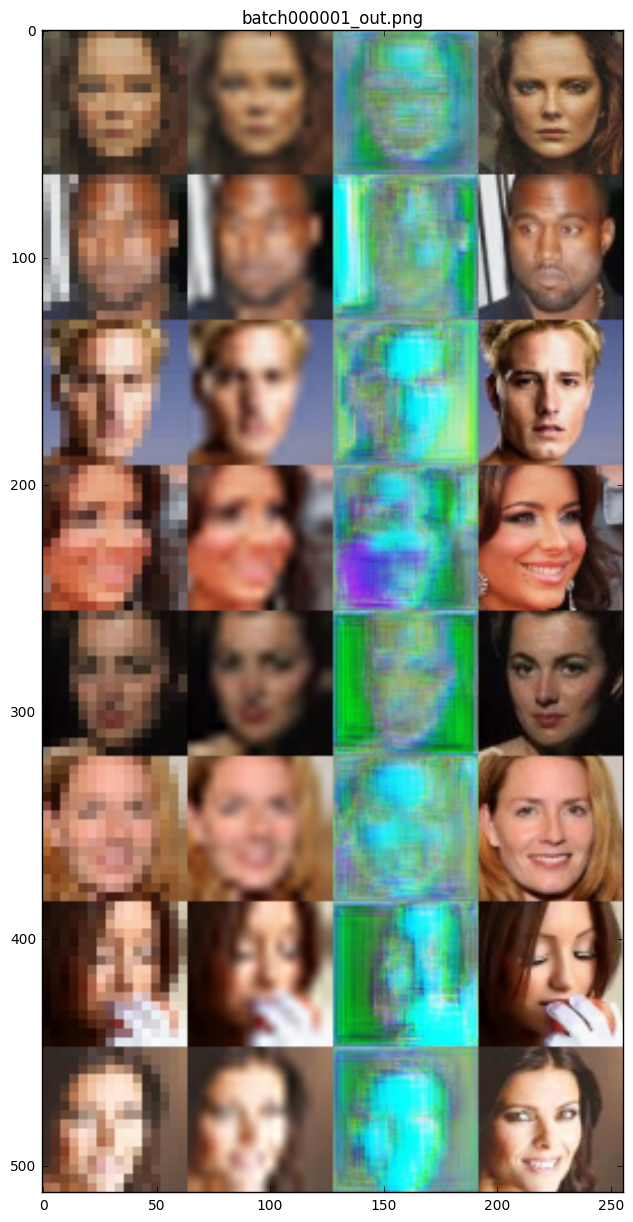

Progress[  0%], ETA[  20m], Batch [ 200], G_Loss[0.205], D_Real_Loss[0.700], D_Fake_Loss[0.634]
Progress[  0%], ETA[  20m], Batch [ 400], G_Loss[0.167], D_Real_Loss[0.632], D_Fake_Loss[0.787]
Progress[  0%], ETA[  20m], Batch [ 600], G_Loss[0.268], D_Real_Loss[0.735], D_Fake_Loss[0.424]
Progress[  5%], ETA[  19m], Batch [ 800], G_Loss[0.208], D_Real_Loss[0.718], D_Fake_Loss[0.599]
Progress[  5%], ETA[  19m], Batch [1000], G_Loss[0.226], D_Real_Loss[0.775], D_Fake_Loss[0.544]
Progress[  5%], ETA[  19m], Batch [1200], G_Loss[0.179], D_Real_Loss[0.543], D_Fake_Loss[0.729]
Progress[ 10%], ETA[  18m], Batch [1400], G_Loss[0.171], D_Real_Loss[0.535], D_Fake_Loss[0.787]
Progress[ 10%], ETA[  18m], Batch [1600], G_Loss[0.216], D_Real_Loss[0.680], D_Fake_Loss[0.529]
Progress[ 10%], ETA[  18m], Batch [1800], G_Loss[0.190], D_Real_Loss[0.508], D_Fake_Loss[0.640]
Progress[ 15%], ETA[  17m], Batch [2000], G_Loss[0.164], D_Real_Loss[0.395], D_Fake_Loss[0.779]
Progress[ 15%], ETA[  17m], Batch [2200]

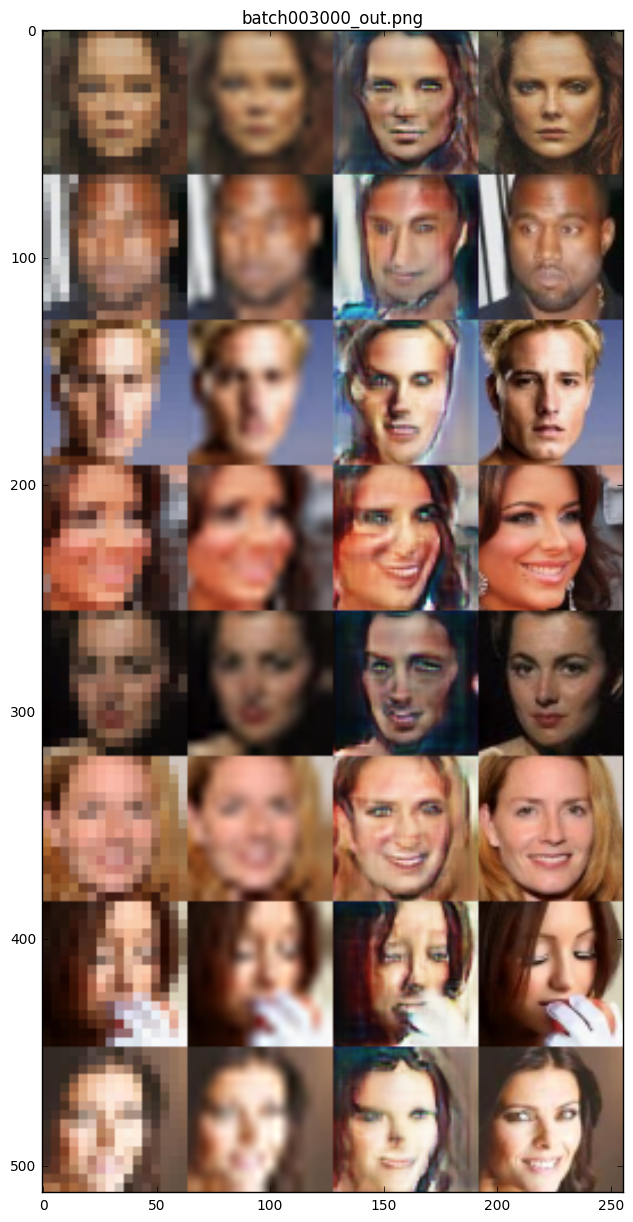

Progress[ 20%], ETA[  16m], Batch [3200], G_Loss[0.311], D_Real_Loss[0.835], D_Fake_Loss[0.327]
Progress[ 25%], ETA[  15m], Batch [3400], G_Loss[0.186], D_Real_Loss[0.334], D_Fake_Loss[0.740]
Progress[ 25%], ETA[  15m], Batch [3600], G_Loss[0.201], D_Real_Loss[0.403], D_Fake_Loss[0.663]
Progress[ 25%], ETA[  15m], Batch [3800], G_Loss[0.428], D_Real_Loss[0.561], D_Fake_Loss[0.182]
Progress[ 30%], ETA[  14m], Batch [4000], G_Loss[0.404], D_Real_Loss[0.578], D_Fake_Loss[0.216]
Progress[ 30%], ETA[  14m], Batch [4200], G_Loss[0.319], D_Real_Loss[1.041], D_Fake_Loss[0.323]
Progress[ 30%], ETA[  14m], Batch [4400], G_Loss[0.133], D_Real_Loss[0.283], D_Fake_Loss[1.330]
Progress[ 35%], ETA[  13m], Batch [4600], G_Loss[0.294], D_Real_Loss[0.631], D_Fake_Loss[0.351]
Progress[ 35%], ETA[  13m], Batch [4800], G_Loss[0.318], D_Real_Loss[0.247], D_Fake_Loss[0.400]
Progress[ 35%], ETA[  13m], Batch [5000], G_Loss[0.298], D_Real_Loss[0.384], D_Fake_Loss[0.383]
Progress[ 35%], ETA[  13m], Batch [5200]

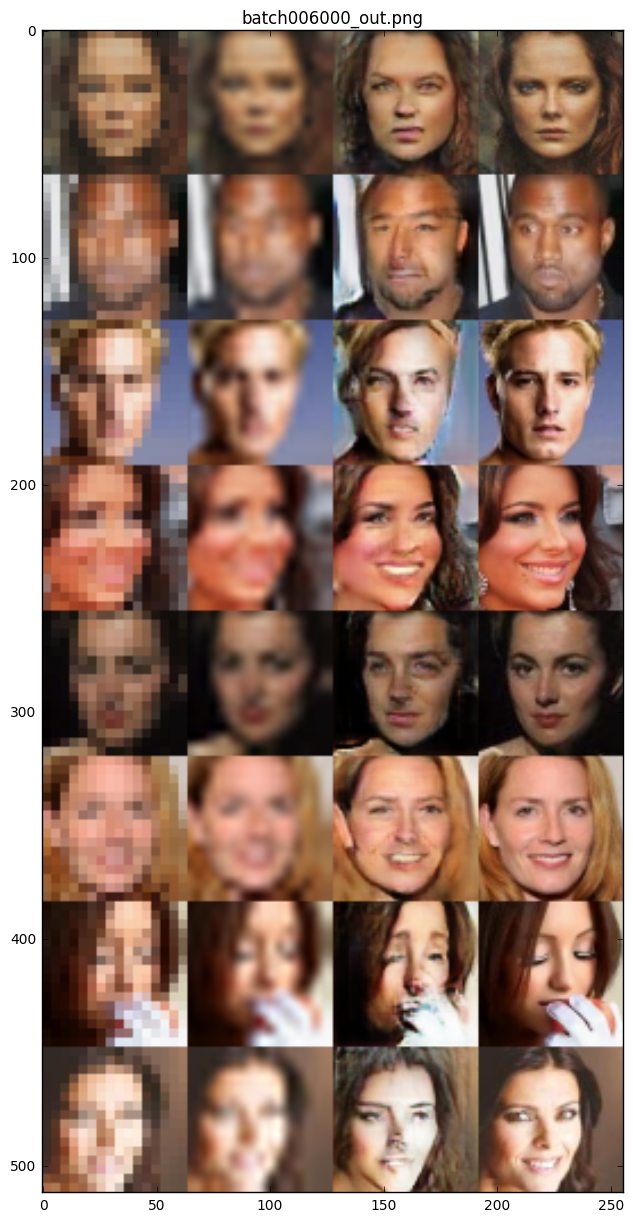

Progress[ 45%], ETA[  11m], Batch [6200], G_Loss[0.324], D_Real_Loss[0.425], D_Fake_Loss[0.297]
Progress[ 45%], ETA[  11m], Batch [6400], G_Loss[0.205], D_Real_Loss[0.313], D_Fake_Loss[0.625]
Progress[ 50%], ETA[  10m], Batch [6600], G_Loss[0.167], D_Real_Loss[0.413], D_Fake_Loss[0.896]
Progress[ 50%], ETA[  10m], Batch [6800], G_Loss[0.131], D_Real_Loss[0.141], D_Fake_Loss[1.079]
Progress[ 50%], ETA[  10m], Batch [7000], G_Loss[0.307], D_Real_Loss[0.554], D_Fake_Loss[0.326]
Progress[ 55%], ETA[   9m], Batch [7200], G_Loss[0.367], D_Real_Loss[0.366], D_Fake_Loss[0.227]
Progress[ 55%], ETA[   9m], Batch [7400], G_Loss[0.364], D_Real_Loss[0.628], D_Fake_Loss[0.257]
Progress[ 55%], ETA[   9m], Batch [7600], G_Loss[0.236], D_Real_Loss[0.848], D_Fake_Loss[0.520]
Progress[ 60%], ETA[   8m], Batch [7800], G_Loss[0.368], D_Real_Loss[0.838], D_Fake_Loss[0.251]
Progress[ 60%], ETA[   8m], Batch [8000], G_Loss[0.256], D_Real_Loss[0.164], D_Fake_Loss[0.542]
Progress[ 60%], ETA[   8m], Batch [8200]

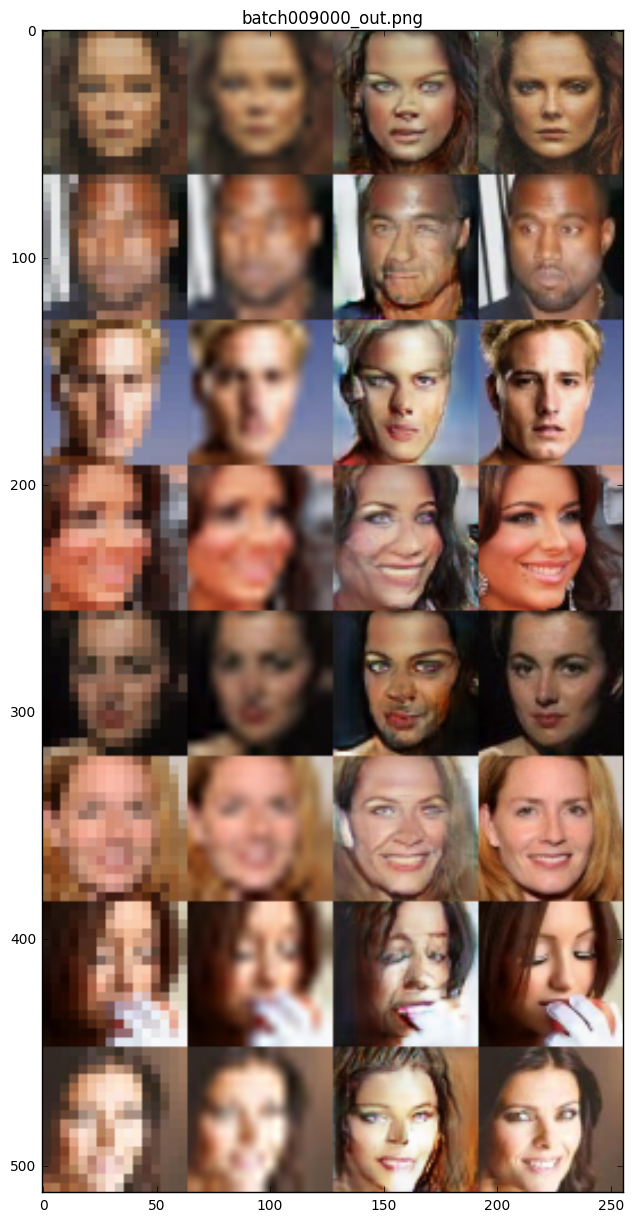

Progress[ 70%], ETA[   6m], Batch [9200], G_Loss[0.457], D_Real_Loss[0.364], D_Fake_Loss[0.155]
Progress[ 70%], ETA[   6m], Batch [9400], G_Loss[0.387], D_Real_Loss[0.687], D_Fake_Loss[0.220]
Progress[ 70%], ETA[   6m], Batch [9600], G_Loss[0.345], D_Real_Loss[0.874], D_Fake_Loss[0.289]
Progress[ 75%], ETA[   5m], Batch [9800], G_Loss[0.344], D_Real_Loss[0.420], D_Fake_Loss[0.281]
Progress[ 75%], ETA[   5m], Batch [10000], G_Loss[0.264], D_Real_Loss[0.151], D_Fake_Loss[0.475]
    Checkpoint saved
Progress[ 75%], ETA[   5m], Batch [10200], G_Loss[0.208], D_Real_Loss[0.220], D_Fake_Loss[0.630]


In [ ]:
train_model(train_data)
print ("TRAINING DONE.")